In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/pj/jqxzlr5d7bvc9htm5rrxf8th0000gs/T/ipykernel_43643/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

2017-08-23


<Axes: title={'center': 'Precipitation Over Time'}, xlabel='Date', ylabel='Precipitation (mm)'>

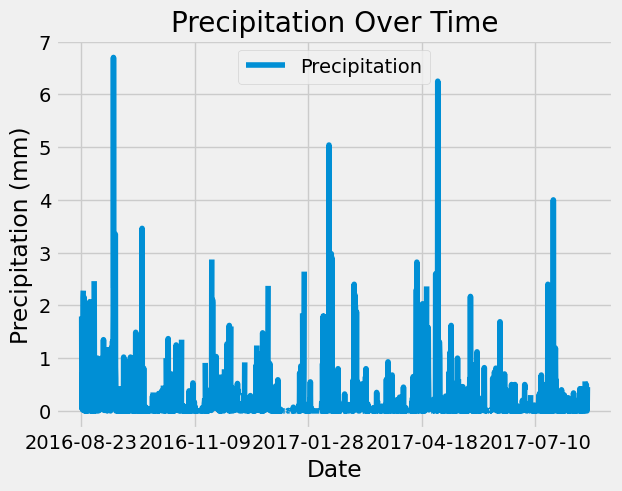

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
precipitation_df.head()

# Sort the dataframe by date
precipitation_df=precipitation_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="Date", y="Precipitation", xlabel="Date", ylabel="Precipitation (mm)", title="Precipitation Over Time")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Station.station).count()
print(num_stations)

9


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = func.count(Measurement.station)
active_stations = session.query(Measurement.station, station_counts).group_by(Measurement.station).order_by(station_counts.desc()).all()
active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Count'])
print(f"The station ids are listed below in descending order (greatest to smallest) of number of observations") 
display(active_stations_df)

The station ids are listed below in descending order (greatest to smallest) of number of observations


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_df.iloc[0]["Station"]
most_active_station_temps = session.query(Measurement.tobs).where(Measurement.station == most_active_station).all()
most_active_station_temps_df = pd.DataFrame(most_active_station_temps, columns=['Temperature'])
display(most_active_station_temps_df.describe())

,Temperature
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


array([[<Axes: title={'center': 'Temperature'}>]], dtype=object)

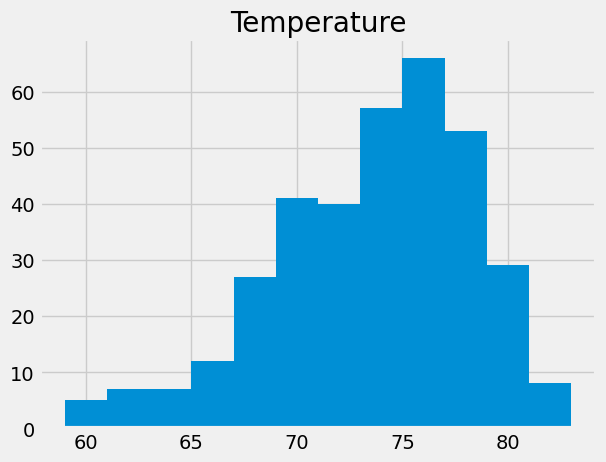

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_12mos_temps = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()
most_active_12mos_temps_df = pd.DataFrame(most_active_12mos_temps, columns=['Temperature'])
most_active_12mos_temps_df.hist(bins=12)

# Close Session

In [18]:
# Close Session
session.close()